# Notes
- FIELDNAME == "XX" has VALUE 0
 - This corresponds to 0 moths for this SITECODE,LCODE,FIELDNAME combination
 - Sites T04 and T06 has overlap with LCODE, so this 0 value may not appear
 
 ## moth groups: G=Geometridae, M=Microlepidotera(large moths) , N=Noctuidae, O=others

In [54]:
## R script of useful functions for the moth/environment analysis
library(tidyverse)
library(feather)
library(dplyr)
library(lubridate)
library(ggplot2)
library(gridExtra)
library(readxl)
library(reticulate)
library(tibble)

setwd("/data/notebooks/jupyterlab-workshop/")

sites <- setNames(
    c(1:10,12),
    c(paste0("T0", 1:9), paste0("T", c(10,12)))
)
print(sites)

T01 T02 T03 T04 T05 T06 T07 T08 T09 T10 T12 
  1   2   3   4   5   6   7   8   9  10  12 


In [55]:
stable_stations <- c("T02-2", "T03-1", "T04-2", "T05-1", "T06-2", "T08-1", "T09-2")

daterange <- c("1950-01-01","2021-01-01")

## Load moth group file

In [56]:
moth_groups <-  readr::read_csv(
    "/data/ecn/moth_groups.csv",
col_types = list(col_character(), col_character(), col_character(), col_character())
)
head(moth_groups)

IM_SPEC,DESC_LATIN,DESC_COMMON,IM_GROUP
<chr>,<chr>,<chr>,<chr>
889,Abraxas grossulariata - Linn,The Magpie,G
888,Abraxas sylvata - Scop,Clouded Magpie,G
638,Abrostola trigemina - Werneb,Dark Spectacle,N
639,Abrostola triplasia - Linn,The Spectacle,N
812,Acasis viretata - Hb,Yellow barred Brindle,G
132,Achlya flavicornis - Linn,Yellow horned,O


## Load moth data

In [57]:
# some of this code is taken from Michael T's functions

# moth data
mothdata <- tibble::as_tibble(read.csv("/data/ecn/ECN_IM1.csv"))
  
# process
dd = mothdata %>%
    # change year format yy to yyyy
    dplyr::mutate(YEAR=as.integer(str_sub(SDATE, start= -2))) %>%
    dplyr::mutate(YEAR=if_else( YEAR <= 50,YEAR+2000,YEAR+1900)) %>%
    dplyr::mutate(DATE= as.Date(SDATE, format= "%d-%b-%y")) %>%
    # drop YEAR and SDATE columns
    dplyr::select(-YEAR,-SDATE) %>%
    # get dates in specified date range
    dplyr::filter(
        as.Date(DATE) >= as.Date(daterange[1]) &
        as.Date(DATE) <= as.Date(daterange[2]) 
    ) %>%
    # remove rows with "Q" in FIELDNAME
    dplyr::filter(!str_detect(FIELDNAME, "Q")) %>%
    # select only valid sites
    filter(SITECODE %in% names(sites)) %>%
    # create station column
    mutate(station = paste0(SITECODE,"-",LCODE)) %>%
    # select only stable stations
    filter(station %in% stable_stations) %>%
    arrange(station, DATE) %>%
    # add moth group information
    right_join(moth_groups, by=c("FIELDNAME"="IM_SPEC")) %>%
    # remove rows added by join (IM_SPEC not observed)
    filter(!is.na(VALUE))
print(dd, n=3)

# A tibble: 85,250 x 9
  SITECODE LCODE FIELDNAME VALUE DATE       station DESC_LATIN DESC_COMMON
  <fct>    <int> <chr>     <int> <date>     <chr>   <chr>      <chr>      
1 T02          2 2178          6 1996-06-26 T02-2   Plutella … Diamond ba…
2 T02          2 504           1 1996-06-26 T02-2   Rusina fe… Brown Rust…
3 T02          2 359           2 1996-06-27 T02-2   Lacanobia… Pale shoul…
# … with 85,247 more rows, and 1 more variable: IM_GROUP <chr>


# Calculate count daily count by: station,IM_GROUP then rate

In [58]:
dd_daily <- dd %>% 
    group_by(DATE,station,IM_GROUP) %>%
    summarize(count = sum(VALUE)) %>%
    ungroup() %>%
    arrange(station,IM_GROUP,DATE) %>%
    mutate(
        lag_DATE = lag(DATE,1), 
        lag_station = lag(station, 1), 
        lag_IM_GROUP = lag(IM_GROUP,1), 
        interval = as.double(DATE - lag_DATE),
        useful_row = 
            (station == lag_station) &
            (IM_GROUP == lag_IM_GROUP) ) %>%
    filter(useful_row == TRUE) %>%
    select(DATE, station, IM_GROUP, count, interval) %>%
    mutate(rate = count/interval, month=lubridate::month(DATE))
print(dd_daily, n=3)

`summarise()` regrouping output by 'DATE', 'station' (override with `.groups` argument)



# A tibble: 33,679 x 7
  DATE       station IM_GROUP count interval  rate month
  <date>     <chr>   <chr>    <int>    <dbl> <dbl> <dbl>
1 1996-06-29 T02-2   G            1        1  1        6
2 1996-06-30 T02-2   G            2        1  2        6
3 1996-07-04 T02-2   G            1        4  0.25     7
# … with 33,676 more rows


## Plot count by: group,station

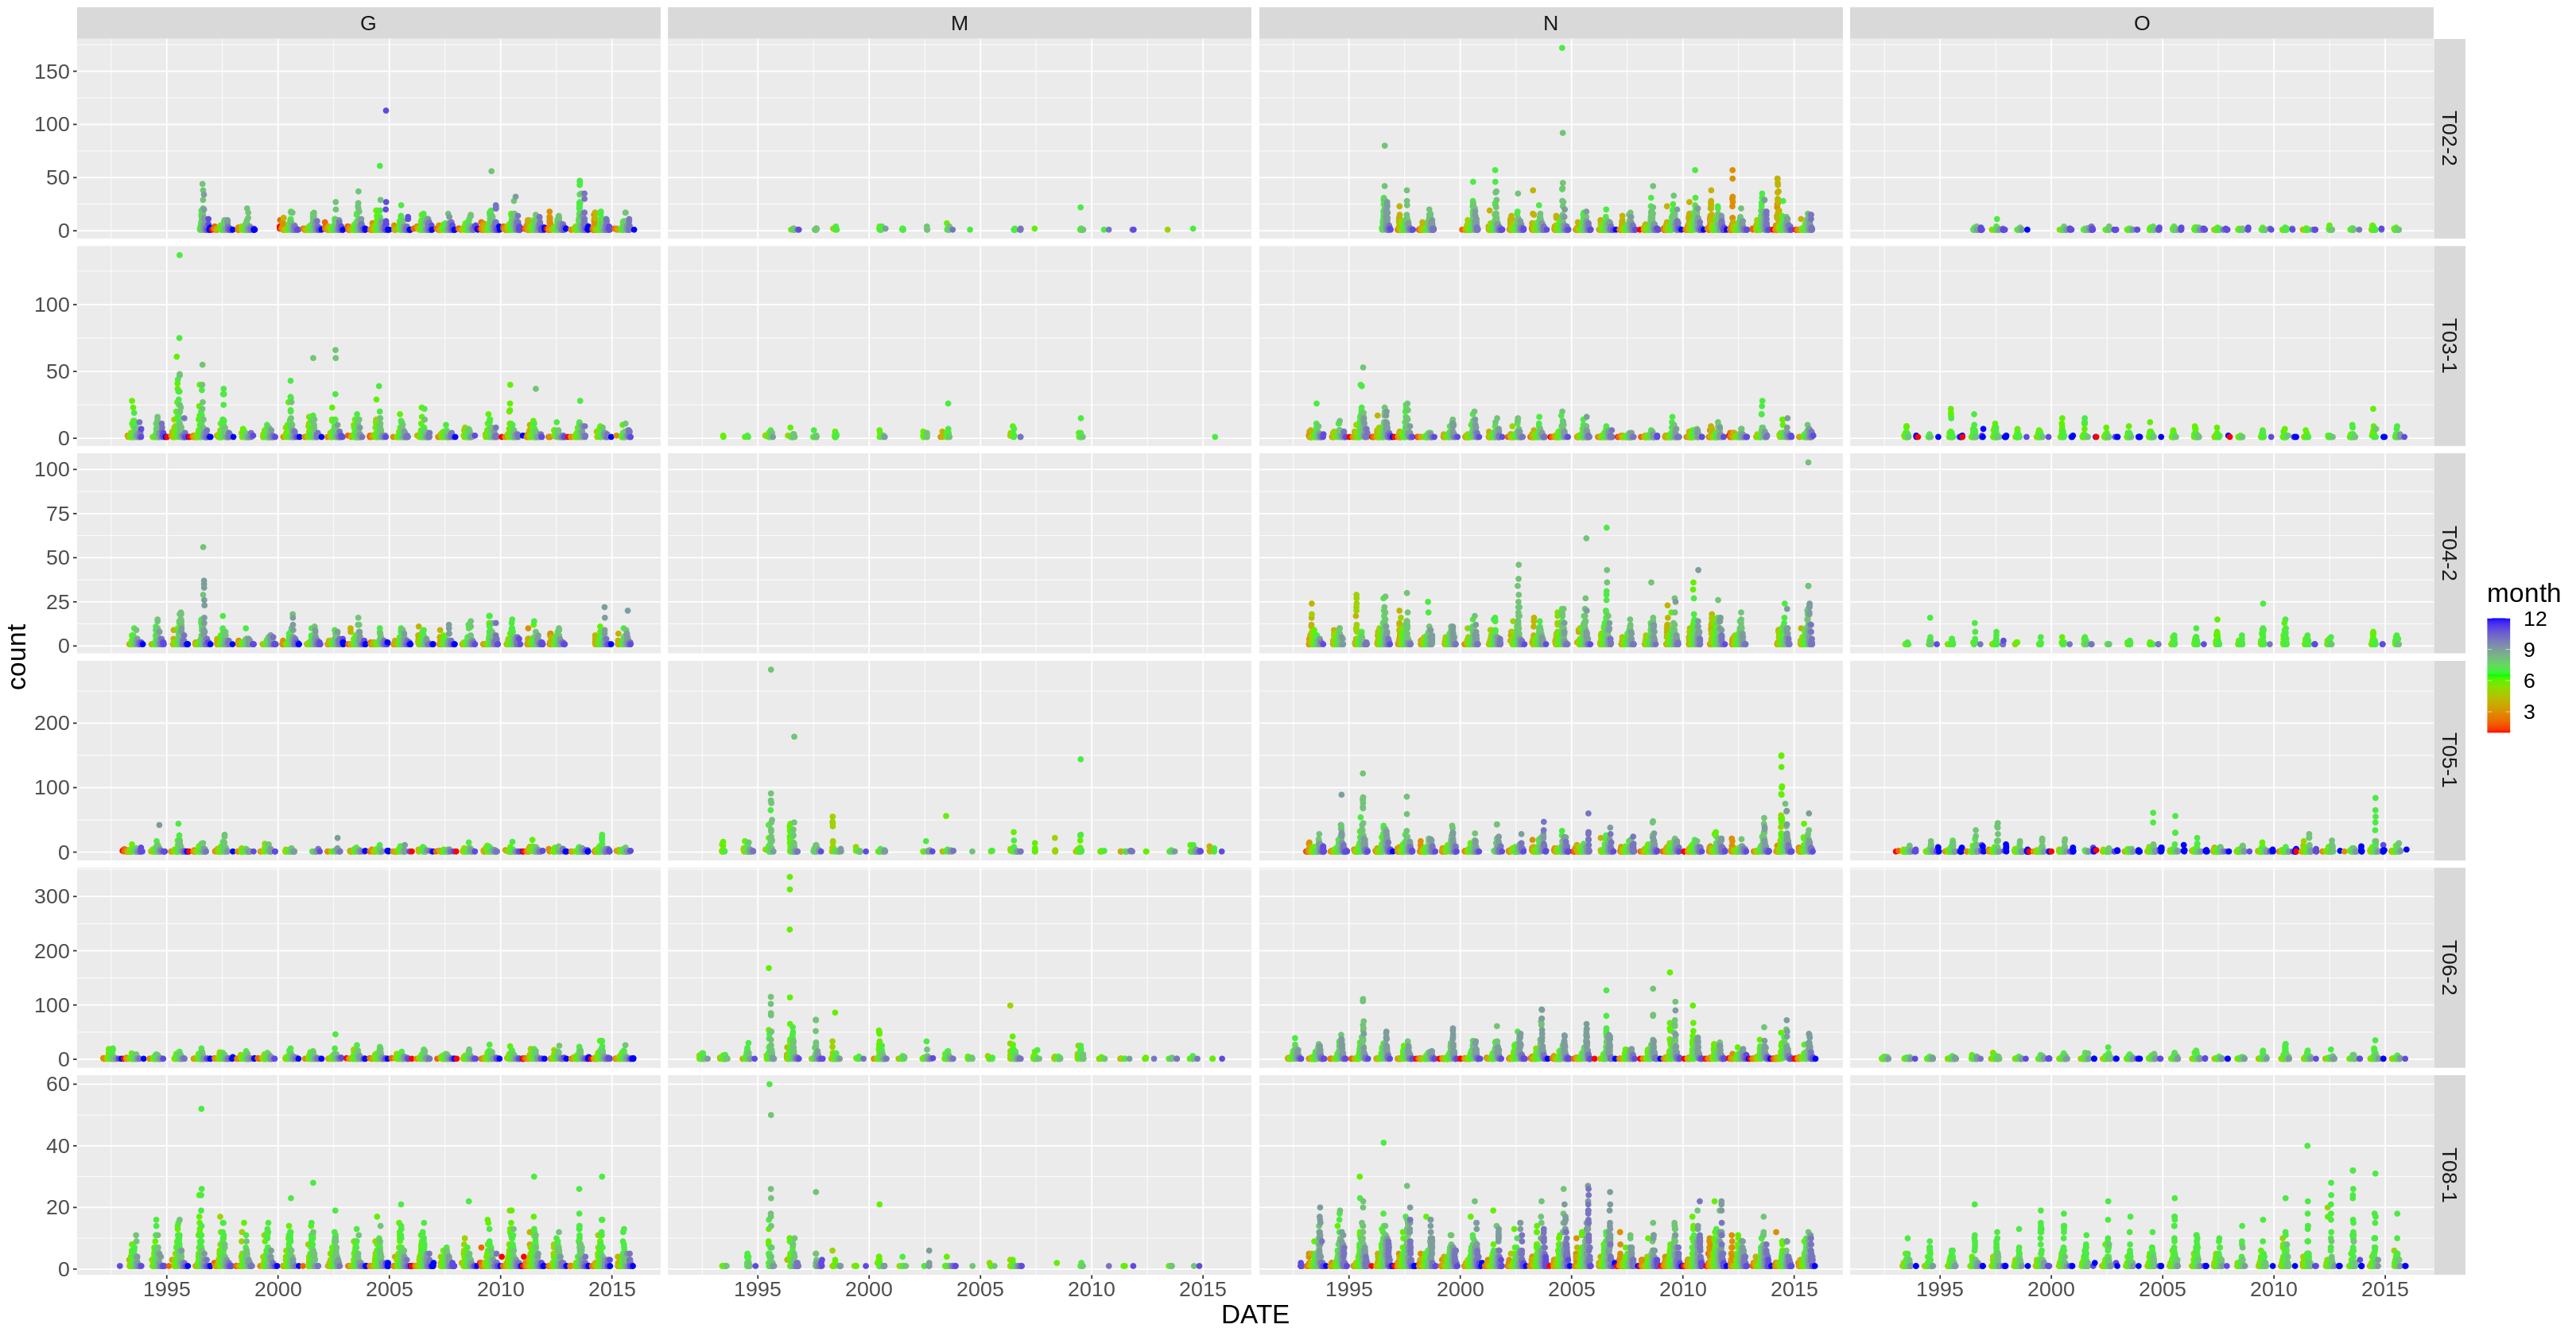

In [59]:
options(repr.plot.width = 27, repr.plot.height = 14)

dd_daily %>%
    ggplot(aes(x=DATE, y=count, color=month)) +
    scale_color_gradientn(colours = rainbow(3)) +
    geom_point() +
    facet_grid(row=vars(station), col=vars(IM_GROUP), scales="free_y") +
    theme(text = element_text(size=20))

## Plot rate by: group, station

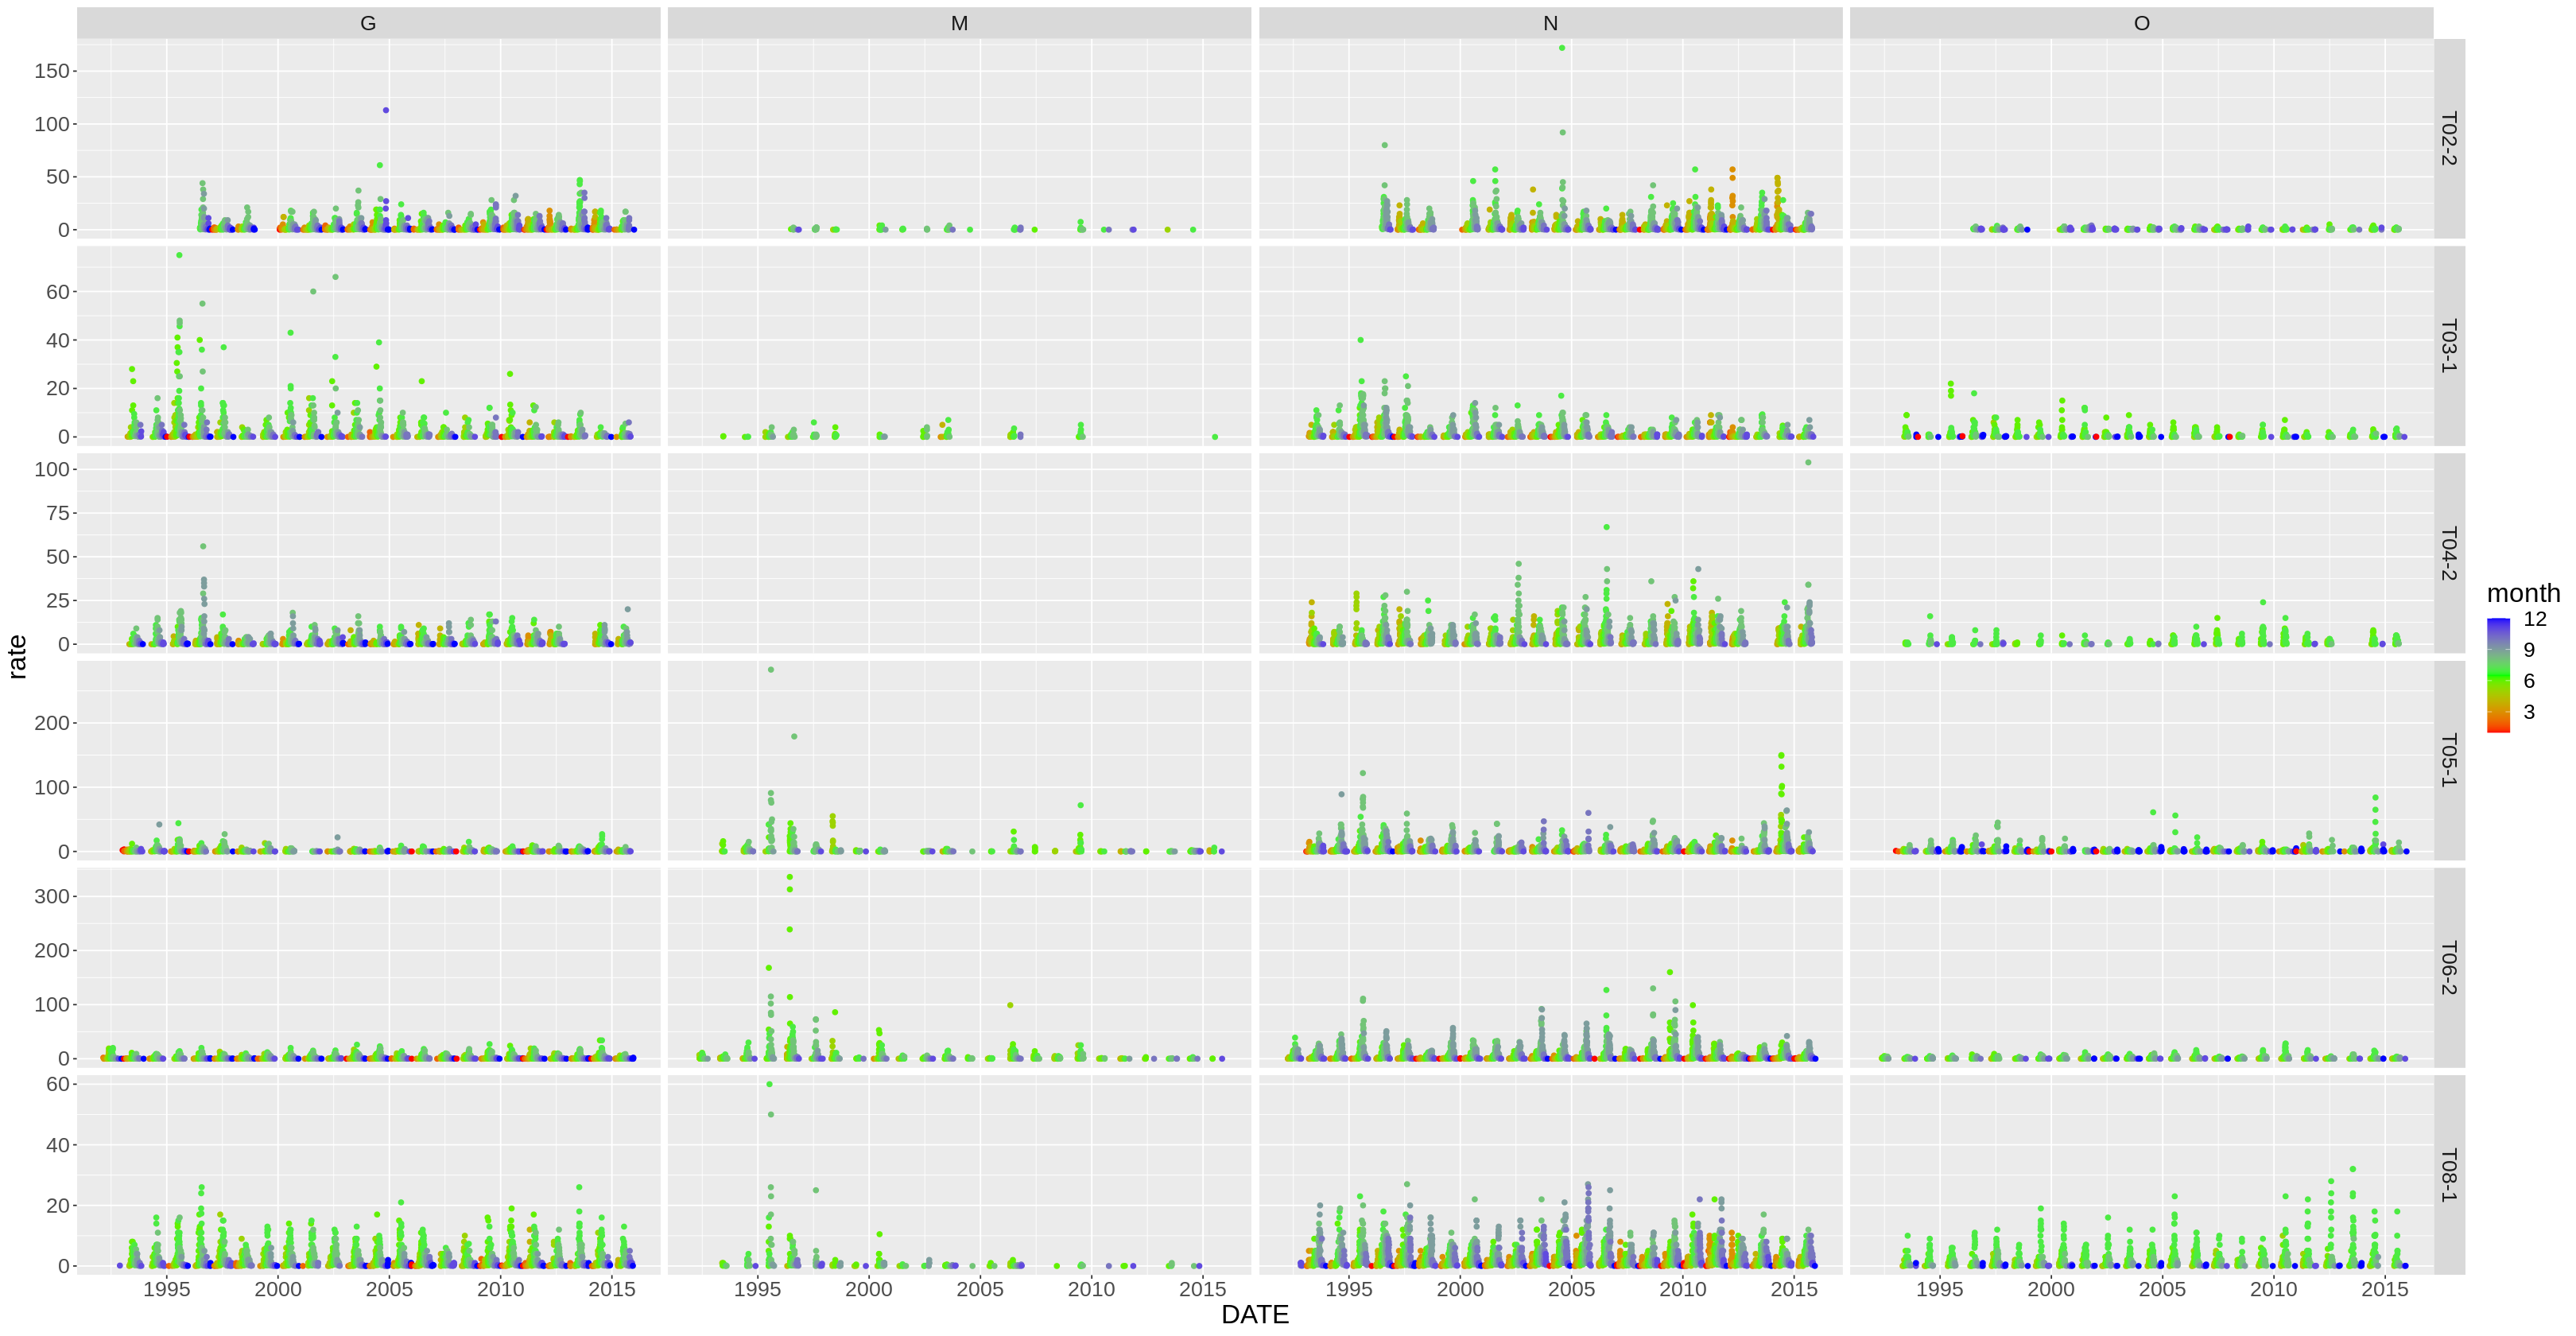

In [64]:
options(repr.plot.width = 27, repr.plot.height = 14)

dd_daily %>%
    ggplot(aes(x=DATE, y=rate, color=month)) +
    scale_color_gradientn(colours = rainbow(3)) +
    geom_point() +
    facet_grid(row=vars(station), col=vars(IM_GROUP), scales="free_y") +
    theme(text = element_text(size=20))

## Plot rate by: group, station

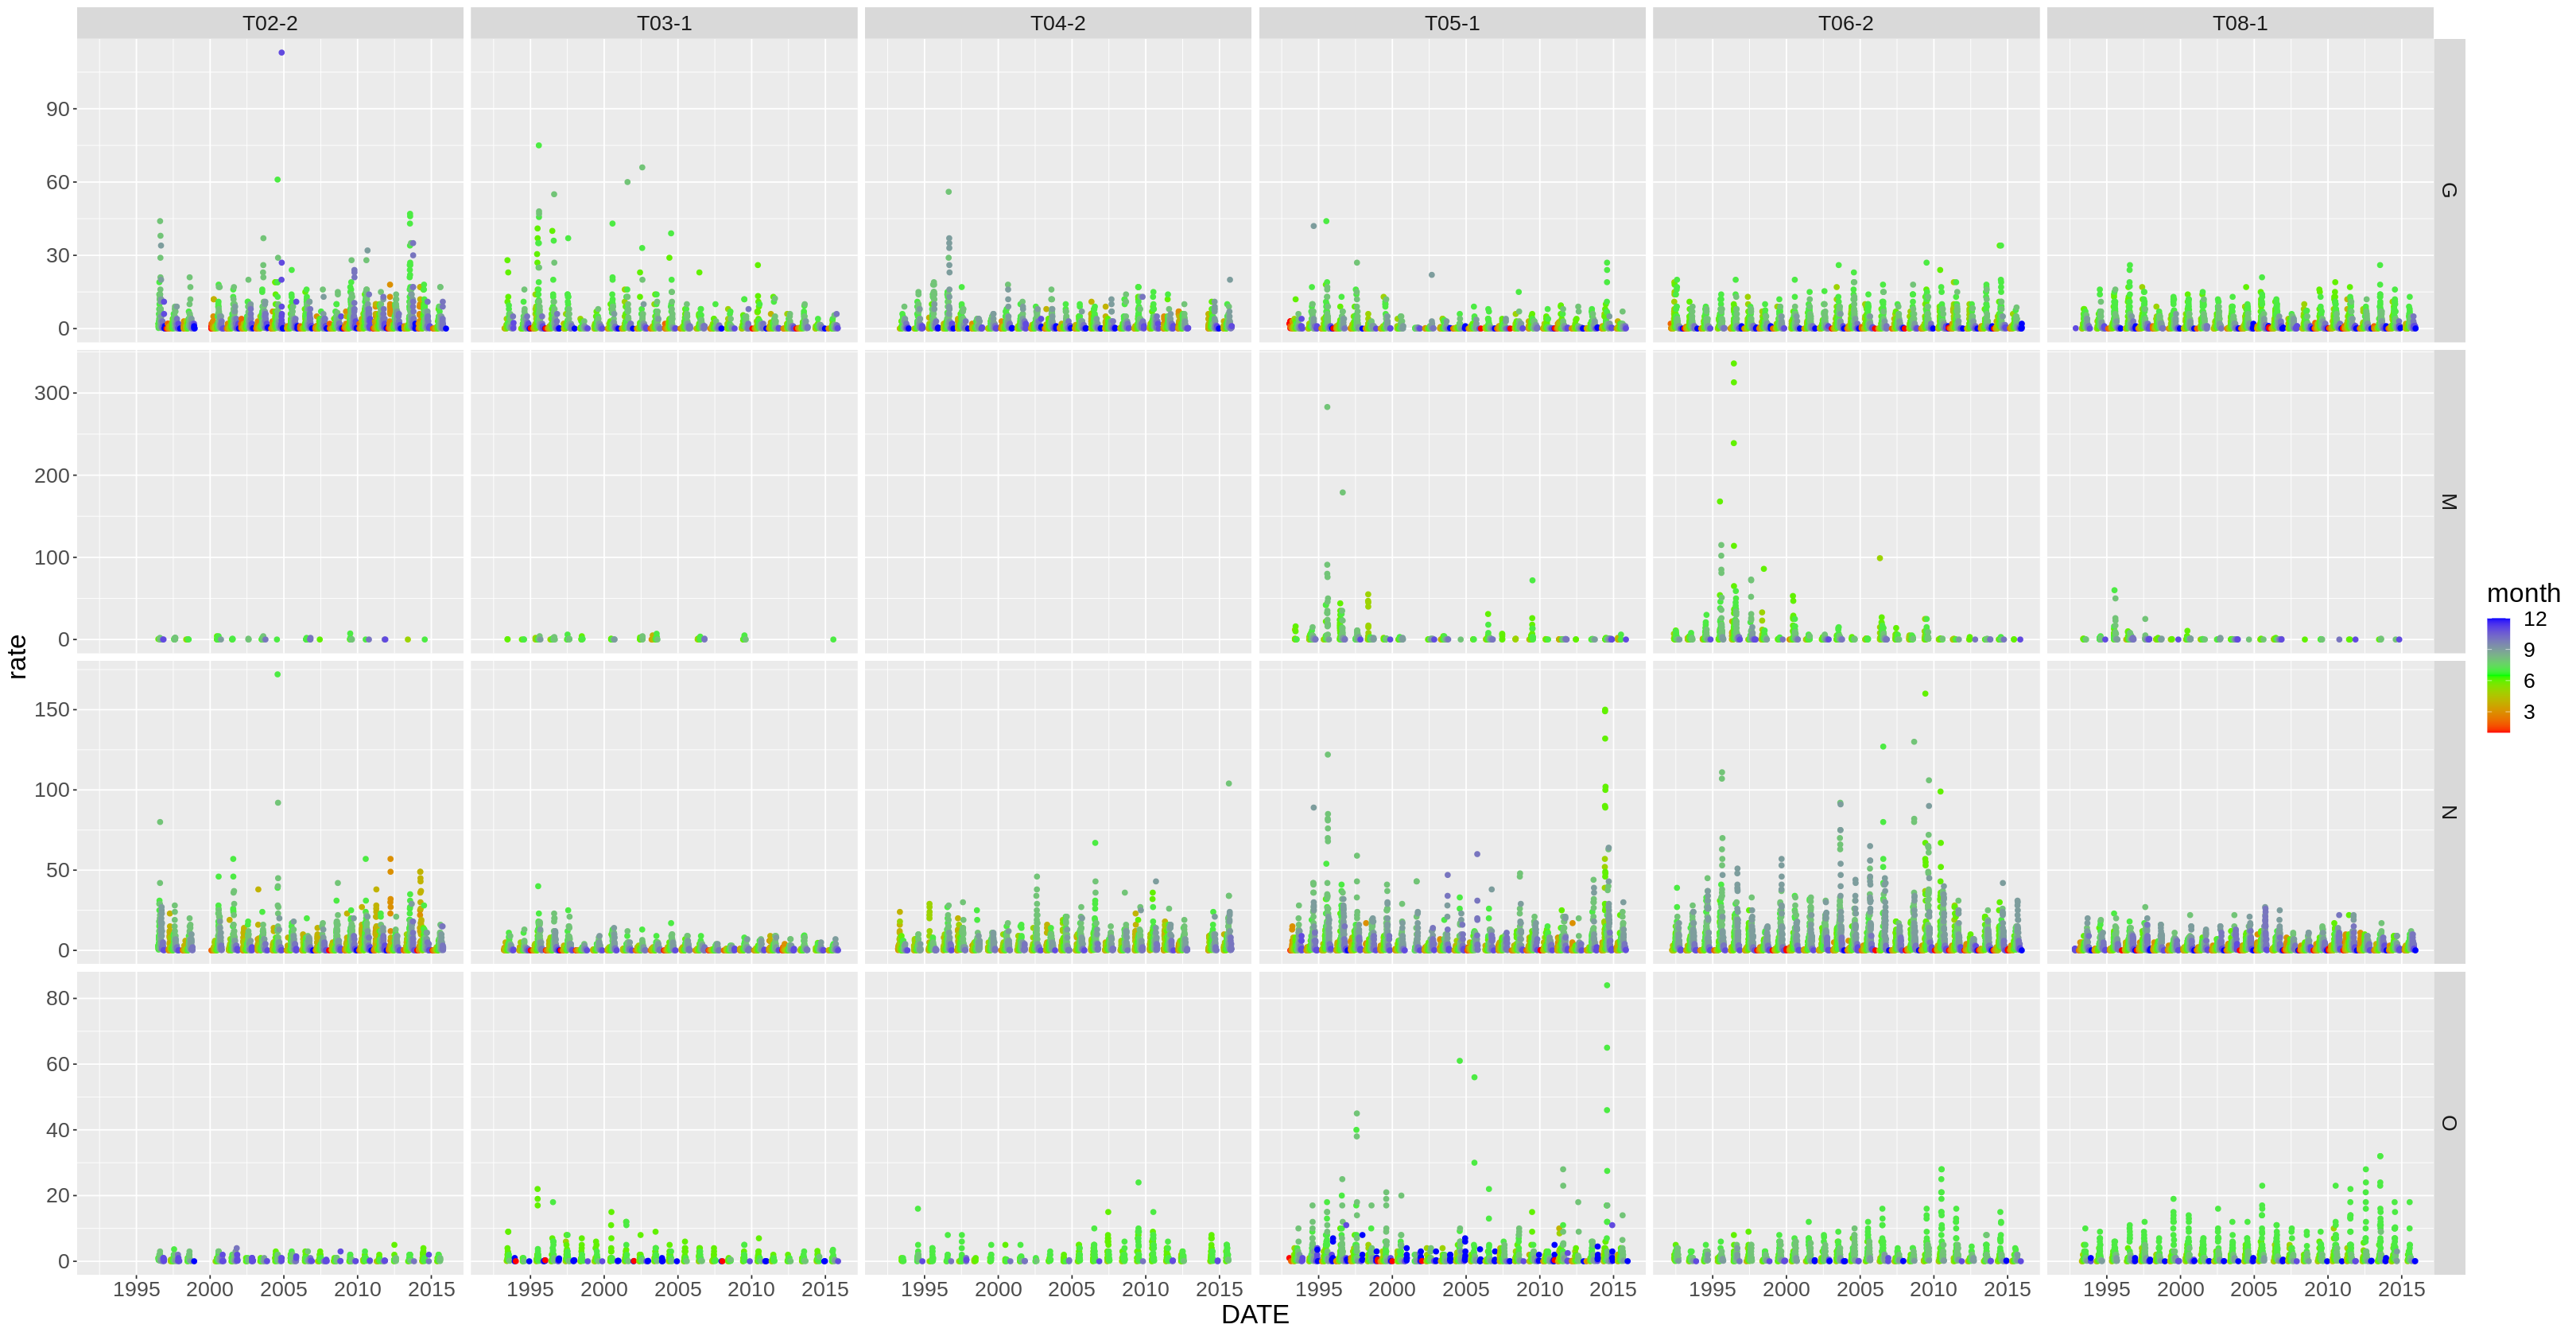

In [61]:
options(repr.plot.width = 27, repr.plot.height = 14)

dd_daily %>%
    ggplot(aes(x=DATE, y=rate, color=month)) +
    scale_color_gradientn(colours = rainbow(3)) +
    geom_point() +
    facet_grid(col=vars(station), row=vars(IM_GROUP), scales="free_y") +
    theme(text = element_text(size=20))

# Calculate monthly rate
- could do something to remove part way through months (at begining?)

In [72]:
dd_monthly <- dd_daily %>%
    mutate(days_in_month = lubridate::days_in_month(DATE), 
           year=lubridate::year(DATE), 
           monthname = lubridate::month(DATE, label=TRUE, abbr=FALSE) ) %>%
    group_by(station, IM_GROUP, month, year, days_in_month, monthname) %>%
    summarize(sum_rate = sum(rate)) %>%
    ungroup() %>%
    mutate(
        rate_month = sum_rate/days_in_month,
        date= as.Date(paste(year,monthname,days_in_month,sep='-'), format="%Y-%B-%d")
    ) %>%
    arrange(station,IM_GROUP,date)
head(dd_monthly)

`summarise()` regrouping output by 'station', 'IM_GROUP', 'month', 'year', 'days_in_month' (override with `.groups` argument)



station,IM_GROUP,month,year,days_in_month,monthname,sum_rate,rate_month,date
<chr>,<chr>,<dbl>,<dbl>,<int>,<ord>,<dbl>,<dbl>,<date>
T02-2,G,6,1996,30,June,3.00000,0.1000000,1996-06-30
T02-2,G,7,1996,31,July,120.58333,3.8897849,1996-07-31
T02-2,G,8,1996,31,August,280.50000,9.0483871,1996-08-31
T02-2,G,9,1996,30,September,104.91667,3.4972222,1996-09-30
T02-2,G,10,1996,31,October,15.00000,0.4838710,1996-10-31
T02-2,G,11,1996,30,November,19.47222,0.6490741,1996-11-30


## Plot rate by: group, station

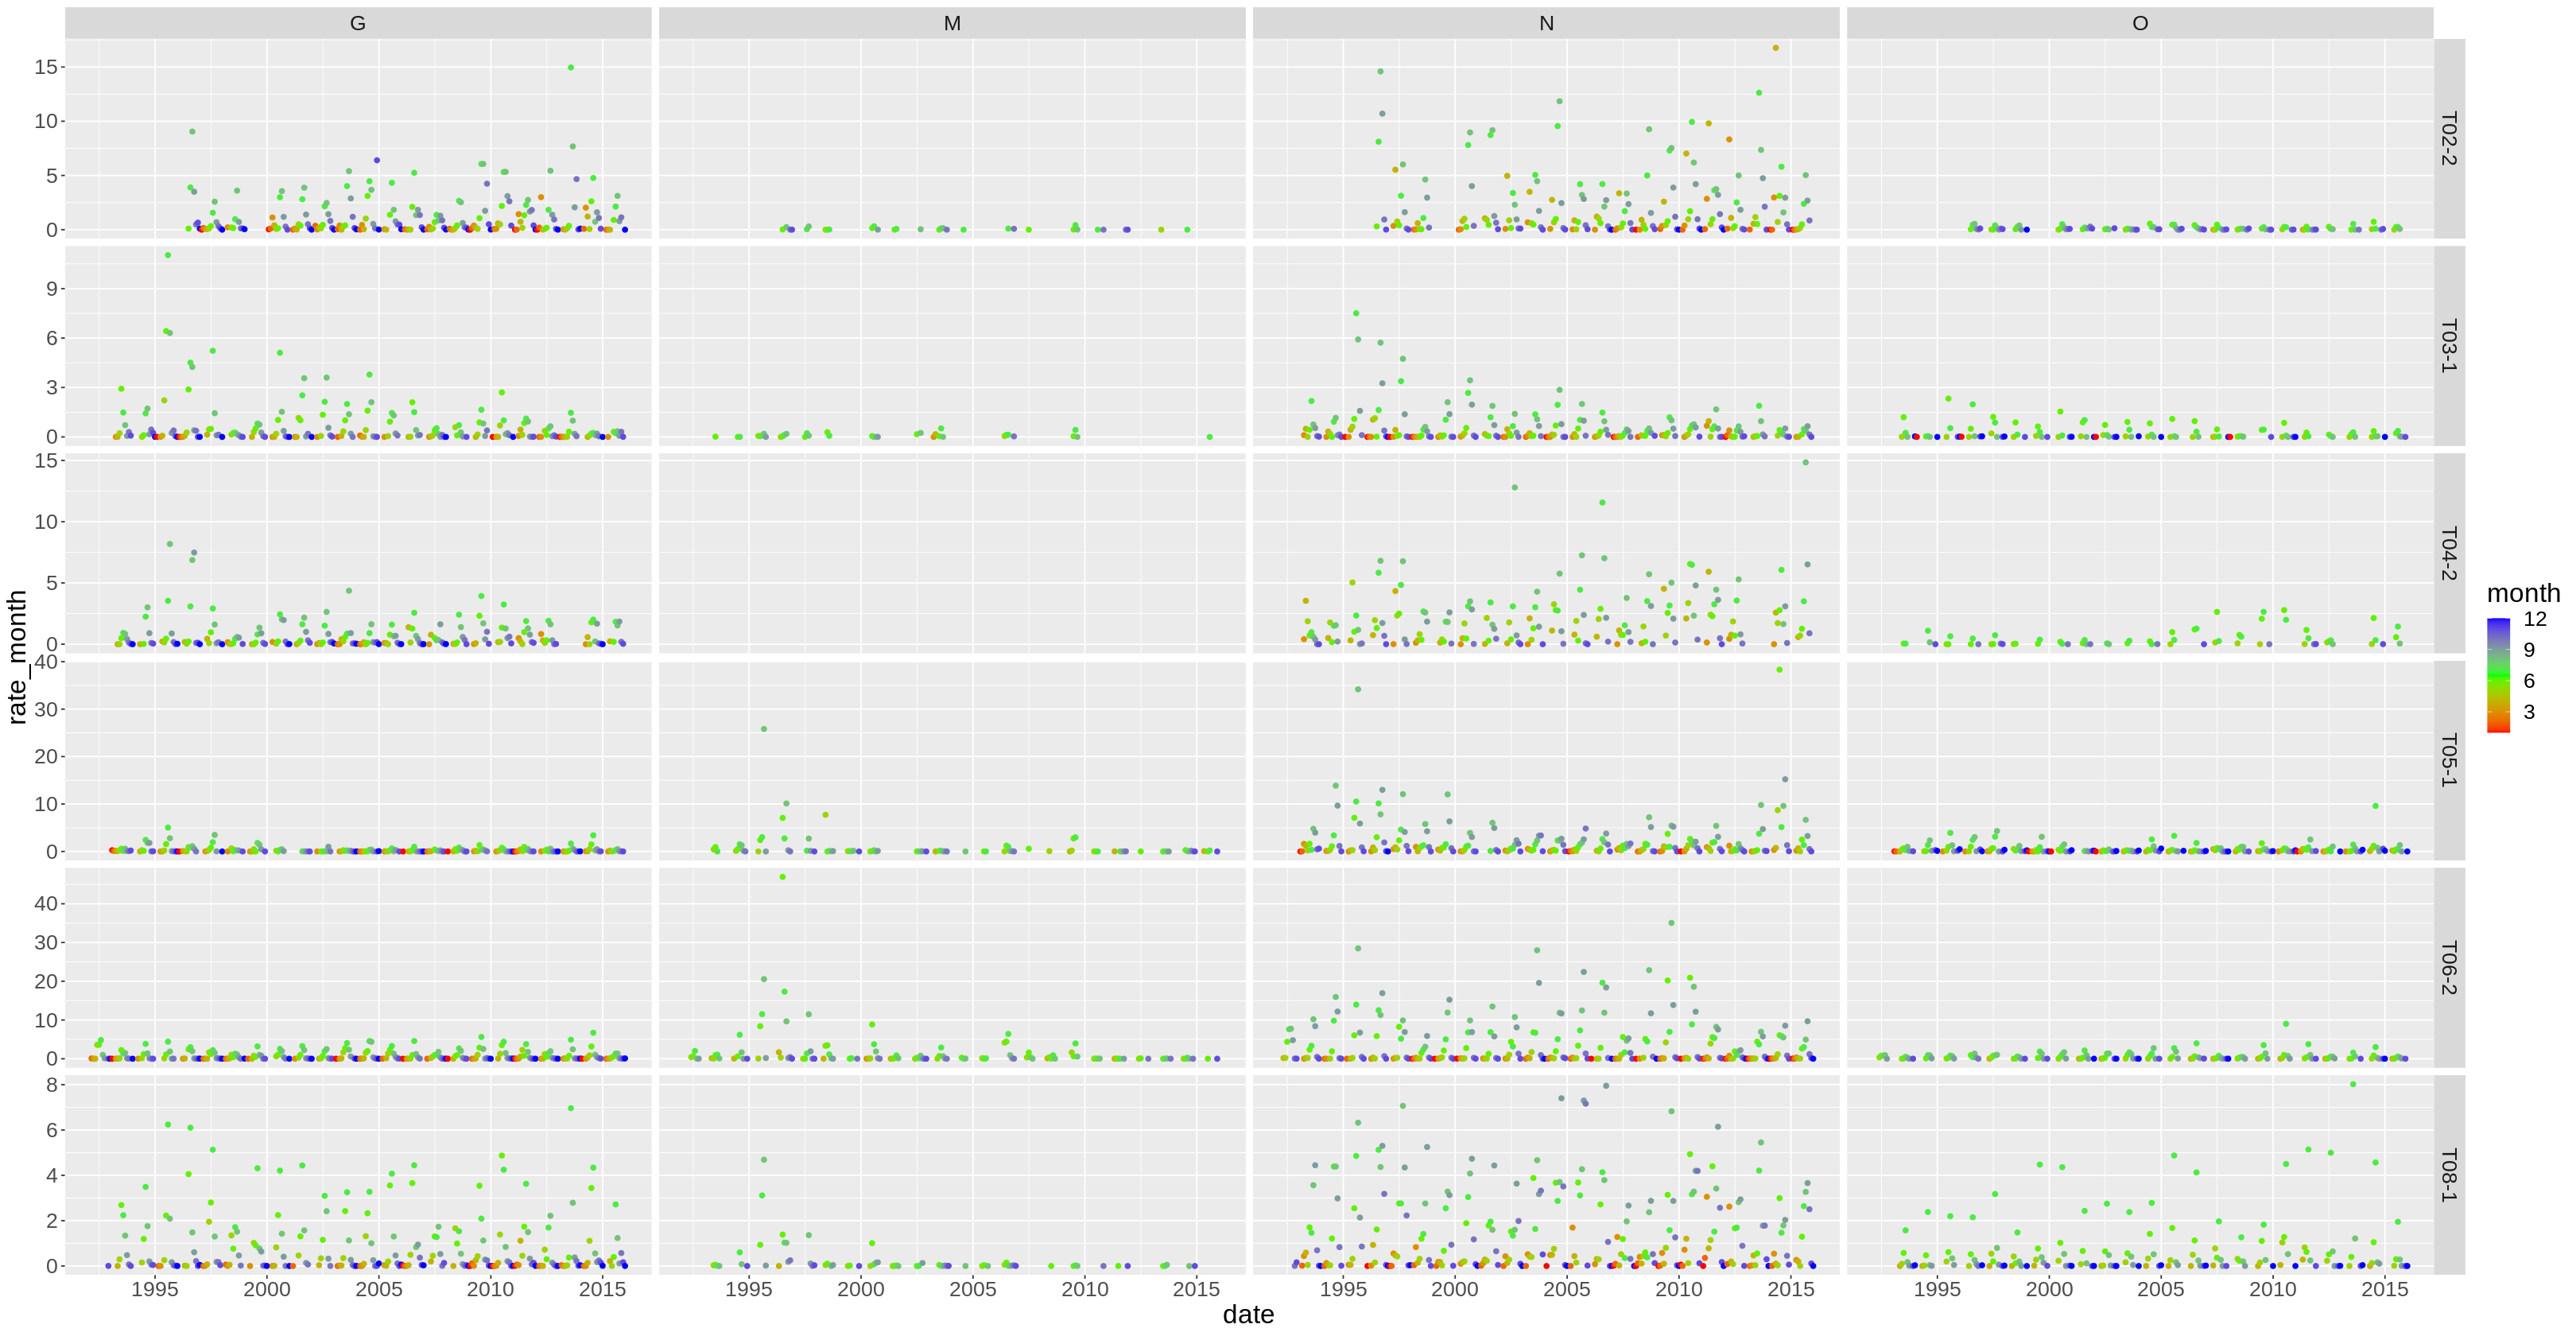

In [73]:
options(repr.plot.width = 27, repr.plot.height = 14)

dd_monthly %>%
    ggplot(aes(x=date, y=rate_month, color=month)) +
    scale_color_gradientn(colours = rainbow(3)) +
    geom_point() +
    facet_grid(row=vars(station), col=vars(IM_GROUP), scales="free_y") +
    theme(text = element_text(size=20))

## Plot rate by: group, station

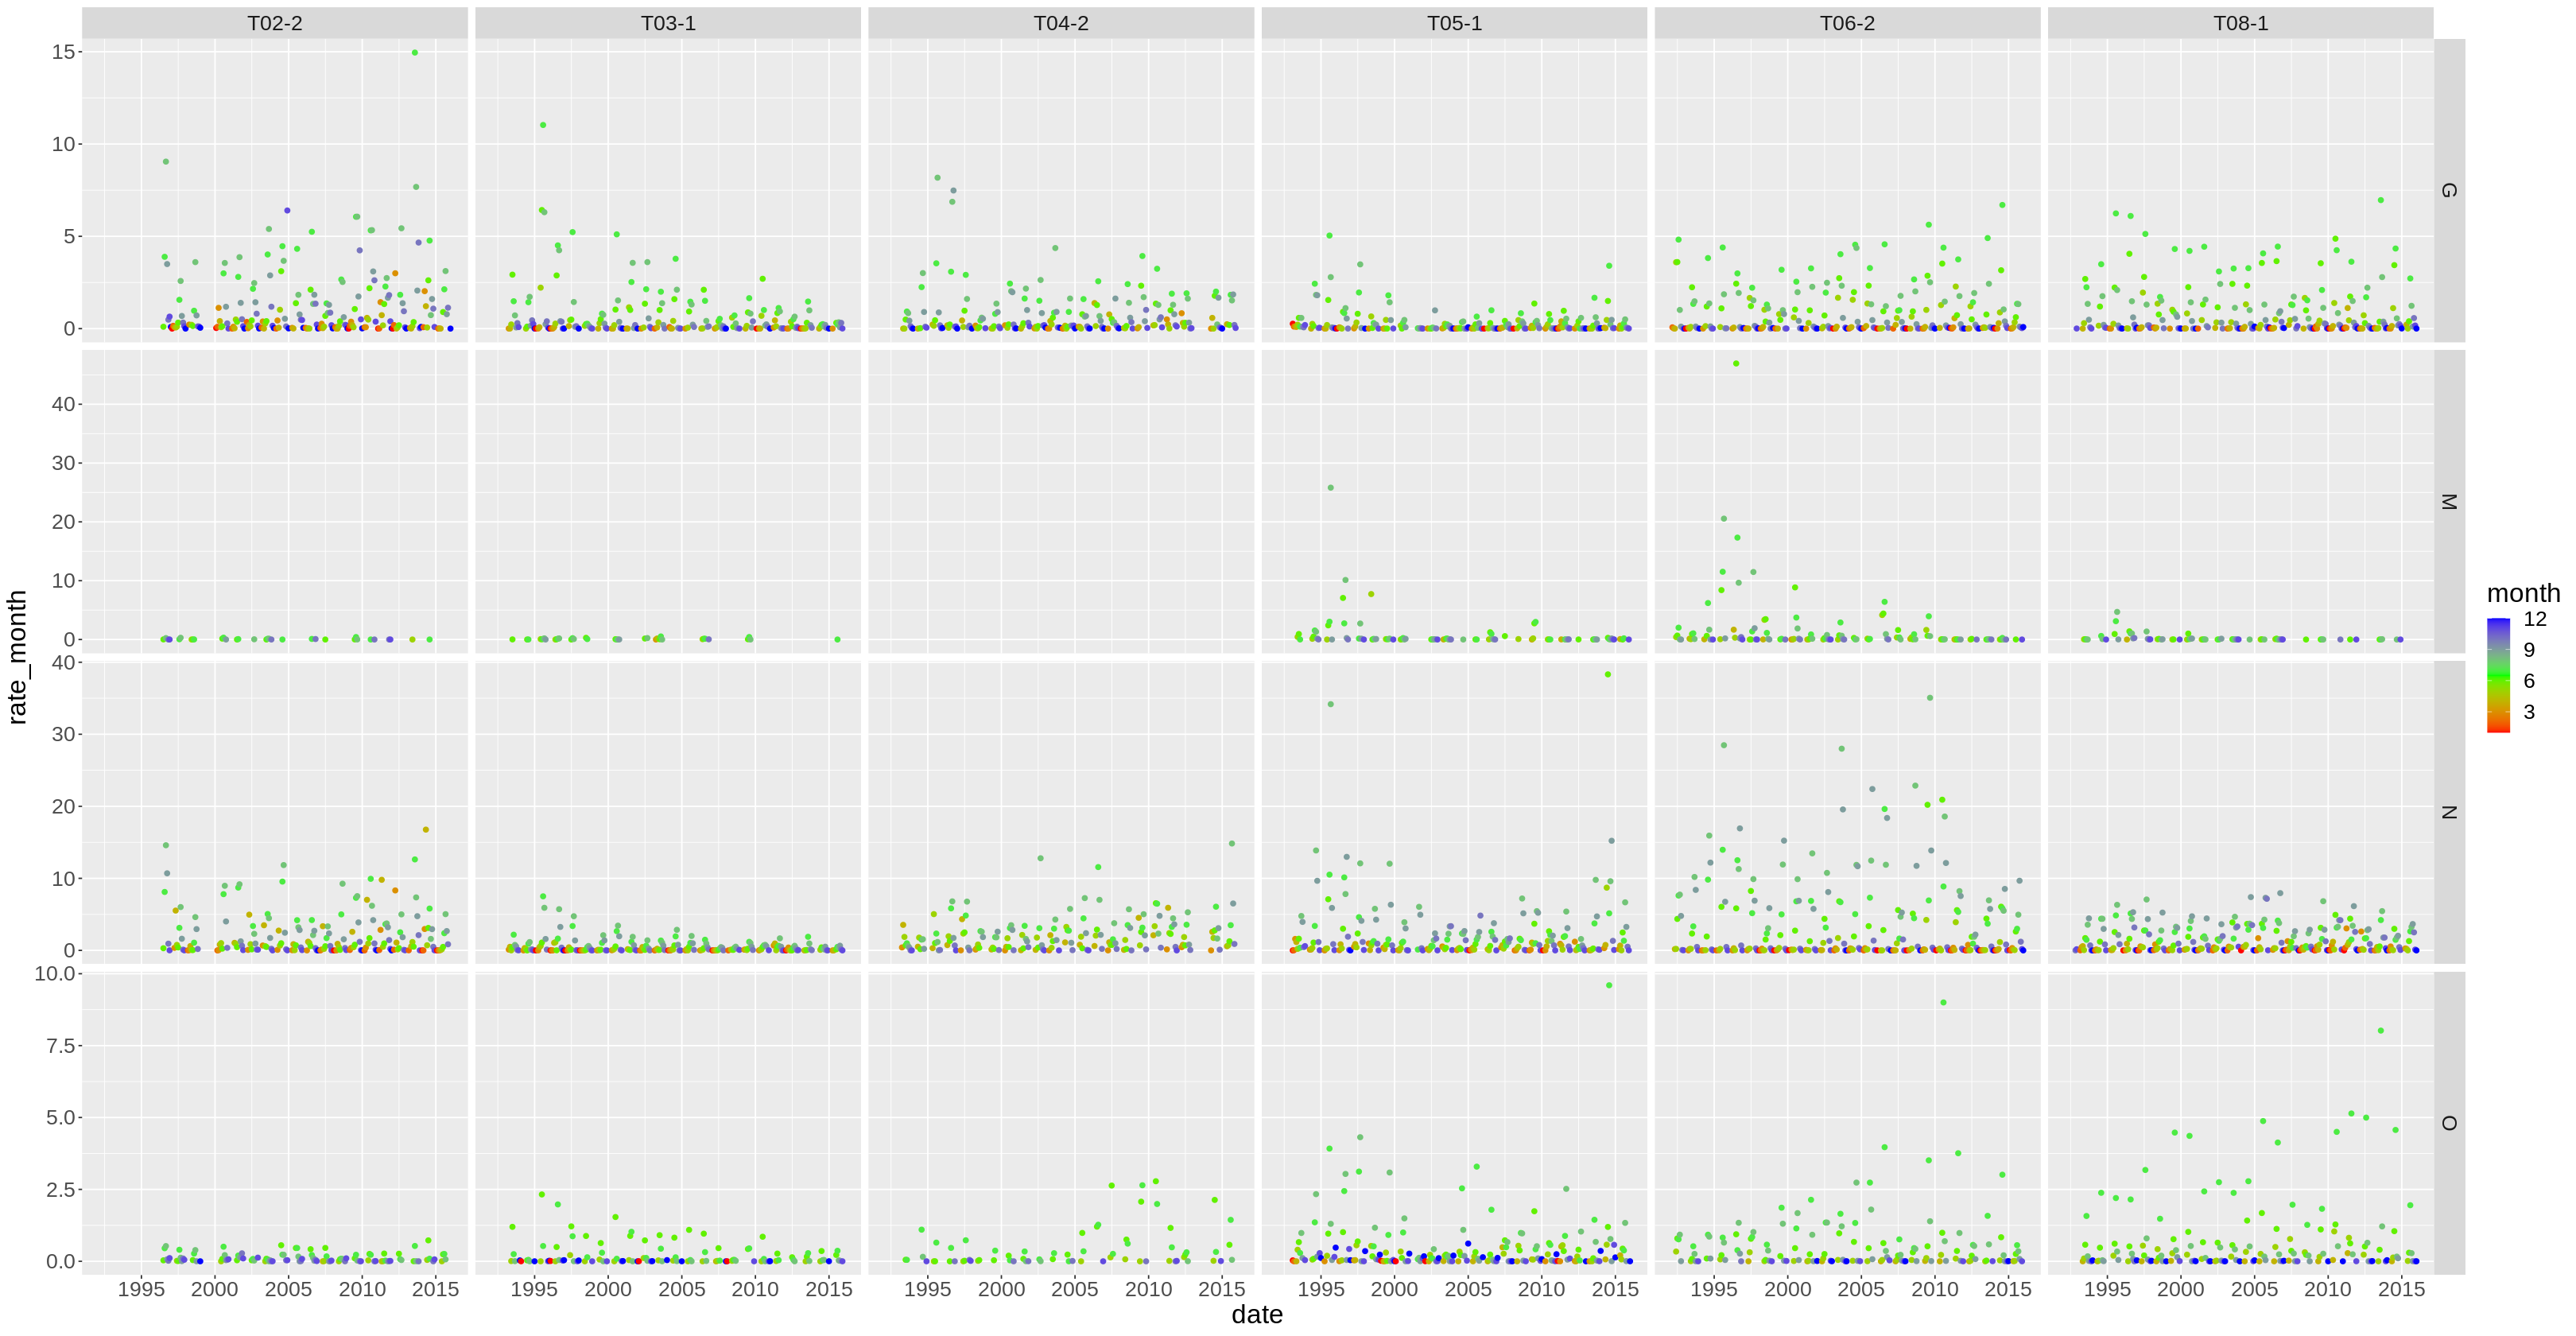

In [74]:
options(repr.plot.width = 27, repr.plot.height = 14)

dd_monthly %>%
    ggplot(aes(x=date, y=rate_month, color=month)) +
    scale_color_gradientn(colours = rainbow(3)) +
    geom_point() +
    facet_grid(col=vars(station), row=vars(IM_GROUP), scales="free_y") +
    theme(text = element_text(size=20))

Seasonality of one species

station,IM_GROUP,month,year,days_in_month,monthname,sum_rate,rate_month,date,yearmonth
<chr>,<chr>,<dbl>,<dbl>,<int>,<ord>,<dbl>,<dbl>,<date>,<mth>
T02-2,N,6,1996,30,June,9.0000000,0.30000000,1996-06-30,1996 Jun
T02-2,N,7,1996,31,July,251.5000000,8.11290323,1996-07-31,1996 Jul
T02-2,N,8,1996,31,August,452.5000000,14.59677419,1996-08-31,1996 Aug
T02-2,N,9,1996,30,September,321.0000000,10.70000000,1996-09-30,1996 Sep
T02-2,N,10,1996,31,October,29.0000000,0.93548387,1996-10-31,1996 Oct
T02-2,N,11,1996,30,November,0.3111111,0.01037037,1996-11-30,1996 Nov


station,IM_GROUP,month,year,days_in_month,monthname,sum_rate,rate_month,date,yearmonth
<chr>,<chr>,<dbl>,<dbl>,<int>,<ord>,<dbl>,<dbl>,<date>,<mth>
T02-2,N,6,1996,30,June,9.0000000,0.30000000,1996-06-30,1996 Jun
T02-2,N,7,1996,31,July,251.5000000,8.11290323,1996-07-31,1996 Jul
T02-2,N,8,1996,31,August,452.5000000,14.59677419,1996-08-31,1996 Aug
T02-2,N,9,1996,30,September,321.0000000,10.70000000,1996-09-30,1996 Sep
T02-2,N,10,1996,31,October,29.0000000,0.93548387,1996-10-31,1996 Oct
T02-2,N,11,1996,30,November,0.3111111,0.01037037,1996-11-30,1996 Nov


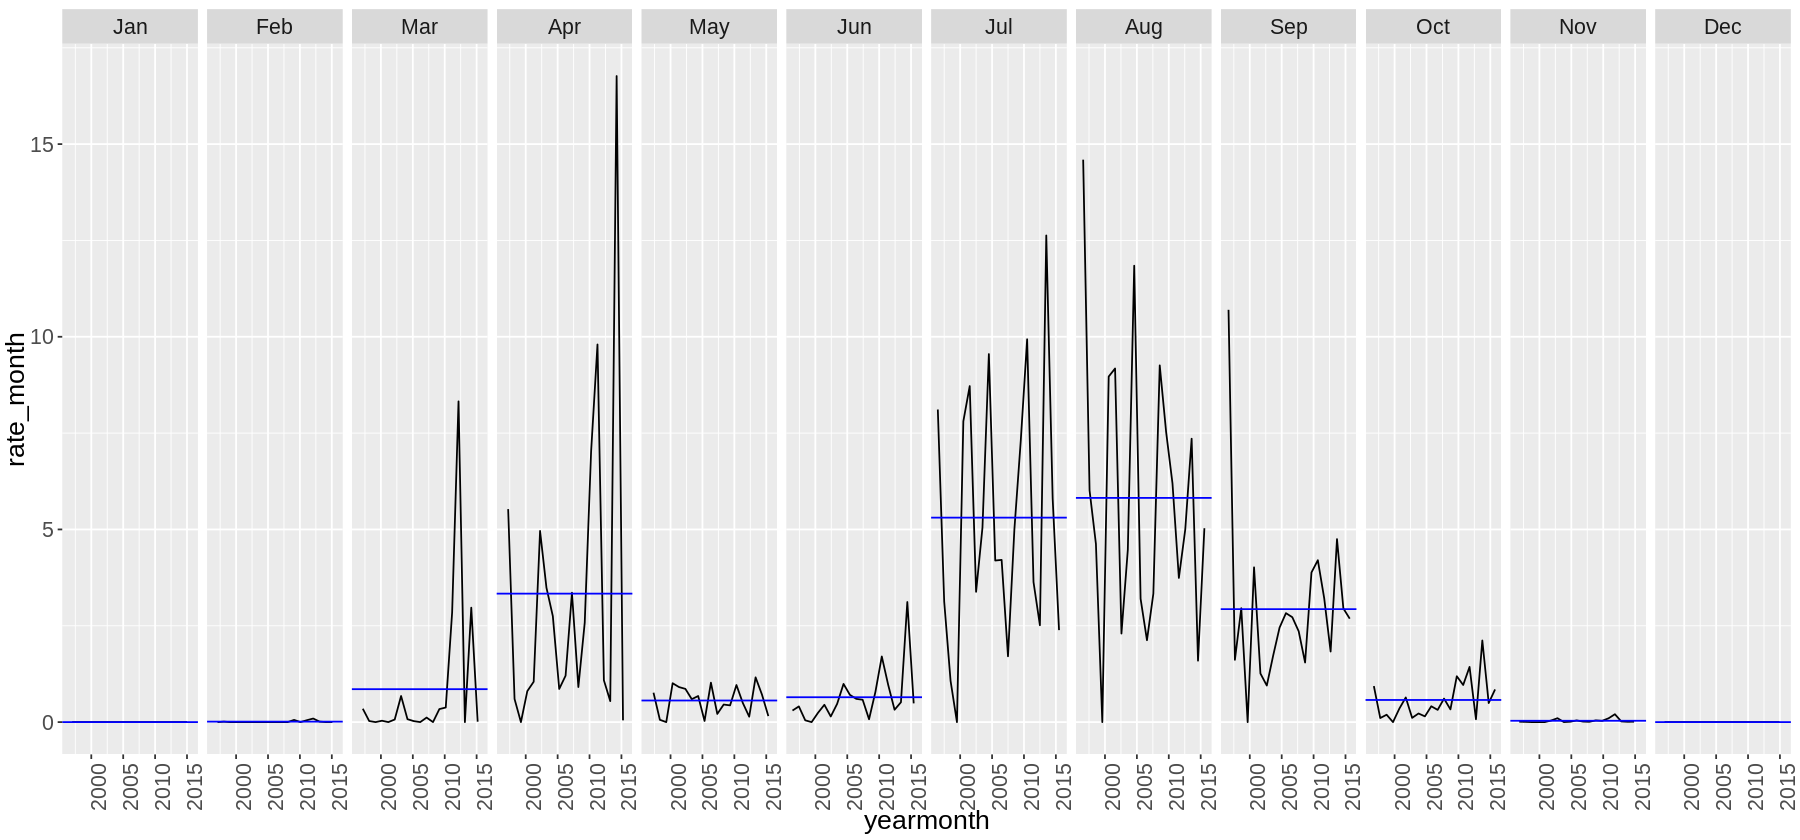

In [96]:
options(repr.plot.width = 15, repr.plot.height = 7)
filtered <- dd_monthly %>%
    filter(IM_GROUP=="N", station == "T02-2") %>%
    mutate(yearmonth = tsibble::yearmonth(date)) 
head(filtered)
date_min <- min(filtered$yearmonth)
date_max <- max(filtered$yearmonth)
alldates <- seq(date_min, date_max, 1)
missing_dates <- alldates[ !(alldates %in% filtered$yearmonth) ]

tmp <- filtered %>%
    full_join(
        tibble::tibble(
            yearmonth = missing_dates,
            rate_month = 0
        ),
        by=c("yearmonth", "rate_month")
    )
head(tmp)
#tsibble::fill_gaps( tmp %>% select(rate_month, yearmonth) )
tmp %>%
   tsibble::as_tsibble(index=yearmonth) %>% 
    feasts::gg_subseries(y=rate_month) + 
    theme(text = element_text(size = 16))

In [2]:
head(dd_daily)

ERROR: Error in head(dd_daily): object 'dd_daily' not found
